# Robot that Promotes Physical Distancing

Social distancing is the practice of purposefully reducing close contact between people. Social distancing is crucial for preventing the spread of contagious illnesses such as COVID-19 (coronavirus). 
COVID-19 can spread through coughing, sneezing and close contact. Minimizing the amount of close contact, will reduce chances of catching the virus and spreading.

Even though physical distancing is defined between 2 people, robots come handy in this scenario too! Assume a cashier or a bank agent that needs the client to keep the distance of more than 6 feet to the counter. In this case a robot/robot eye that can estimate the client's distance and gives warning could come useful. Or imagine a humanoid robot that wants to keep the distance from people so that it won't carry the virus!

<img src="./images/robot.jpg">

## Algorithm

In this notebook we will go through human distance estimation algorithm. In this algorithm we use and combine human pose detection ([OpenPose](https://github.com/CMU-Perceptual-Computing-Lab/openpose)) and depth estimation ([DenseDepth](https://github.com/ialhashim/DenseDepth)). Here we estimate depth from RGB images without need to use depth sensors. 

<img src="./images/approach.png">

# Requirements (if running on your own system)
 - use module cuda 10.1

 - install cudnn 7.6.5 as described here: https://medium.com/@vitali.usau/install-cuda-10-0-cudnn-7-3-and-build-tensorflow-gpu-from-source-on-ubuntu-18-04-3daf720b83fe

 - install tensorflow-gpu 1.14 using pip or conda

 - install keras & opencv-contrib-python using pip or conda
 
# Requirements (if running on Google Colab)
 
 - just run the following cell:

In [38]:
!wget https://github.com/dorsadadjoo/Distance_Estimation/archive/master.zip
!unzip master.zip 
!mv Distance_Estimation-master/* .
!rm -rf Distance_Estimation-master


--2020-07-22 03:17:29--  https://github.com/dorsadadjoo/Distance_Estimation/archive/master.zip
Resolving github.com (github.com)... 140.82.114.4
Connecting to github.com (github.com)|140.82.114.4|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://codeload.github.com/dorsadadjoo/Distance_Estimation/zip/master [following]
--2020-07-22 03:17:29--  https://codeload.github.com/dorsadadjoo/Distance_Estimation/zip/master
Resolving codeload.github.com (codeload.github.com)... 140.82.112.10
Connecting to codeload.github.com (codeload.github.com)|140.82.112.10|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: unspecified [application/zip]
Saving to: ‘master.zip.2’

master.zip.2            [     <=>            ]   5.89M  5.96MB/s    in 1.0s    

2020-07-22 03:17:31 (5.96 MB/s) - ‘master.zip.2’ saved [6175396]

Archive:  master.zip
0f97571da20167d270e1d390db4b79538d57f61e
   creating: Distance_Estimation-master/
  inflating: Distance_Esti

In [39]:
import os
import glob
import numpy as np
import matplotlib
import cv2 as cv
import time
from matplotlib import pyplot as plt
%matplotlib inline

In [40]:
# Keras / TensorFlow
%tensorflow_version 1.x
from keras.models import load_model
from layers import BilinearUpSampling2D
from utils import predict

# DenseDepth

DenseDepth is a standard encoder-decoder architecture that leverages features extracted using high performing pre-trained networks when initializing encoder along with augmentation and training strategies that lead to more accurate results.

<img src="./images/depth.jpeg">

In [41]:
# Download Densedepth pretrained model weights
!wget https://s3-eu-west-1.amazonaws.com/densedepth/nyu.h5

--2020-07-22 03:17:32--  https://s3-eu-west-1.amazonaws.com/densedepth/nyu.h5
Resolving s3-eu-west-1.amazonaws.com (s3-eu-west-1.amazonaws.com)... 52.218.91.43
Connecting to s3-eu-west-1.amazonaws.com (s3-eu-west-1.amazonaws.com)|52.218.91.43|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 172897376 (165M) [application/h5]
Saving to: ‘nyu.h5.2’

nyu.h5.2            100%[===================>] 164.89M  10.7MB/s    in 20s     

2020-07-22 03:17:53 (8.17 MB/s) - ‘nyu.h5.2’ saved [172897376/172897376]



In [42]:
# some parameters
model_checkpoint = 'nyu.h5'
input = 'examples/raw/*.jpg'

In [43]:
# Custom object needed for inference and training
custom_objects = {'BilinearUpSampling2D': BilinearUpSampling2D, 'depth_loss_function': None}

print('Loading model...')

# Load model into GPU / CPU
model = load_model(model_checkpoint, custom_objects=custom_objects, compile=False)
print('Model loaded ({0}).'.format(model_checkpoint))

Loading model...
Model loaded (nyu.h5).


In [44]:
from PIL import Image
def load_images(image_files):
    loaded_images = []
    for file in image_files:
        x = np.clip(np.asarray(Image.open( file ).resize((1280,960)), dtype=float) / 255, 0, 1)
        loaded_images.append(x)
    return np.stack(loaded_images, axis=0)

In [45]:
# Loading input images
inputs = load_images(glob.glob(input))
print('Loaded ({0}) images of size {1}.'.format(inputs.shape[0], inputs.shape[1:]))

Loaded (9) images of size (960, 1280, 3).


In [46]:
# Compute depth maps from DenseDepth
depth_maps = predict(model, inputs)

# OpenPose

OpenPose is a real-time system that can jointly detect human body, hand, facial, and foot keypoints (in total 135 keypoints) on single images.

<img src="./images/openpose.jpeg">

In [47]:
# Download OpenPose pretrained models
!sh get_model.sh

--2020-07-22 03:18:08--  https://raw.githubusercontent.com/CMU-Perceptual-Computing-Lab/openpose/master/models/pose/mpi/pose_deploy_linevec_faster_4_stages.prototxt
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 151.101.0.133, 151.101.64.133, 151.101.128.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|151.101.0.133|:443... connected.
HTTP request sent, awaiting response... 416 Range Not Satisfiable

    The file is already fully retrieved; nothing to do.

--2020-07-22 03:18:09--  http://posefs1.perception.cs.cmu.edu/OpenPose/models/pose/mpi/pose_iter_160000.caffemodel
Resolving posefs1.perception.cs.cmu.edu (posefs1.perception.cs.cmu.edu)... 128.2.176.37
Connecting to posefs1.perception.cs.cmu.edu (posefs1.perception.cs.cmu.edu)|128.2.176.37|:80... connected.
HTTP request sent, awaiting response... 416 Requested Range Not Satisfiable

    The file is already fully retrieved; nothing to do.



In [48]:
def body_points(proto, model, frame, depth_map, dataset="MPI", width=368, height=368, thr=0.1):

    if dataset=='MPI':
        
        BODY_PARTS = { "Head": 0, "Neck": 1, "RShoulder": 2, "RElbow": 3, "RWrist": 4,
                       "LShoulder": 5, "LElbow": 6, "LWrist": 7, "RHip": 8, "RKnee": 9,
                       "RAnkle": 10, "LHip": 11, "LKnee": 12, "LAnkle": 13, "Chest": 14,
                       "Background": 15 }

        POSE_PAIRS = [ ["Head", "Neck"], ["Neck", "RShoulder"], ["RShoulder", "RElbow"],
                       ["RElbow", "RWrist"], ["Neck", "LShoulder"], ["LShoulder", "LElbow"],
                       ["LElbow", "LWrist"], ["Neck", "Chest"], ["Chest", "RHip"], ["RHip", "RKnee"],
                       ["RKnee", "RAnkle"], ["Chest", "LHip"], ["LHip", "LKnee"], ["LKnee", "LAnkle"] ]
    else:
        return
    

    net = cv.dnn.readNetFromCaffe(proto, model) # open pose network

    # inp is a blob from input image
    inp = cv.dnn.blobFromImage(frame, 1.0 / 255, (width, height),
                               (0, 0, 0), swapRB=False, crop=False)
    net.setInput(inp) # given to network (open pose)
    out = net.forward() 
    

    headToNeck = 1
    points = []
    distances = []    
    for i in range(len(BODY_PARTS)):
        # Slice heatmap of corresponding body's part.
        heat_map = out[0, i, :, :]
       
        heat_map_resized =  cv.resize(heat_map,(width, height))
        distances.append(np.mean(heat_map_resized*depth_map)) 
        # fig, ax = plt.subplots()
        # im = ax.imshow(heatMap*depth_map_resized)
        # plt.show()
        
        _, conf, _, point = cv.minMaxLoc(heat_map_resized)
        x = point[0]
        y = point[1]
        # these lines are for keeping  each body point's x,y. 
        # Add a point if it's confidence is higher than threshold.
        points.append((int(x), int(y)) if conf > thr else None)

    
    for pair in POSE_PAIRS:
#         print(pair)
        partFrom = pair[0]
        partTo = pair[1]
        assert(partFrom in BODY_PARTS)
        assert(partTo in BODY_PARTS)

        idFrom = BODY_PARTS[partFrom]
        idTo = BODY_PARTS[partTo]
        if points[idFrom] and points[idTo]:
            cv.line(frame, points[idFrom], points[idTo], (255, 74, 0), 3)
            cv.ellipse(frame, points[idFrom], (4, 4), 0, 0, 360, (255, 255, 255), cv.FILLED)
            cv.ellipse(frame, points[idTo], (4, 4), 0, 0, 360, (255, 255, 255), cv.FILLED)
            if idFrom == 0 and idTo == 1 :
                x1 , y1 = points[idFrom]
                x2 , y2 = points[idTo]
                headToNeck = ((x1-x2)**2+(y1-y2)**2)**0.5

    print("headToNeck = ",headToNeck)
    depth_normalizer = 14000/headToNeck
    mean_distance = np.mean(distances)*depth_normalizer # this is our magic number turning depth map to distance
    print("distance = ",  mean_distance)
    cv.putText(frame, "Distance = "+str(round(mean_distance, 2))+" m ", (20,50), cv.FONT_HERSHEY_SIMPLEX, 0.65, (255, 255, 255),2,cv.LINE_AA)
    # these lines are just to draw those points on the input image (frame)  and connect them with lines.

    return frame


In [49]:
import skimage

#some parameters
pose_proto = 'pose/mpi/pose_deploy_linevec_faster_4_stages.prototxt'
pose_model = 'pose/mpi/pose_iter_160000.caffemodel'
    
def visualize_depth_pose(depth_maps, images=None, is_colormap=True, is_rescale=True):

    all_images = []
    for i in range(depth_maps.shape[0]):
        imgs = []
        
        # images[i] is the input image address
        print(images[i])
        frame = cv.imread(images[i])
        frameWidth = frame.shape[1]
        frameHeight = frame.shape[0]
        depth_map_resized =  cv.resize(depth_maps[i][:,:,0],(frameWidth, frameHeight))


        frame = body_points(proto=pose_proto, 
                                     model=pose_model,
                                     frame=frame,
                                     depth_map=depth_map_resized,
                                     width = frameWidth,
                                     height = frameHeight
                                     )
        # plot current frame with body points
        plt.imshow(frame)
        plt.show()
        
        imgs.append(frame)

        # following lines create a plot of multiple images and depth maps
        color_map = plt.get_cmap('gray')
        if is_colormap:
            rescaled = depth_map_resized
            if is_rescale:
                rescaled = rescaled - np.min(rescaled)
                rescaled = rescaled / np.max(rescaled)                
            imgs.append(color_map(rescaled)[:,:,:3])

        img_set = np.hstack(imgs)
        all_images.append(img_set)

    all_images = np.stack(all_images)

    return skimage.util.montage(all_images, multichannel=True, fill=(0,0,0))

examples/raw/1575_6.29_raw.jpg
headToNeck =  24.0
distance =  5.667258364458879


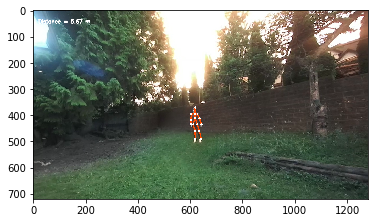

examples/raw/3706_2.84_raw.jpg
headToNeck =  47.51841748206689
distance =  2.879533905524921


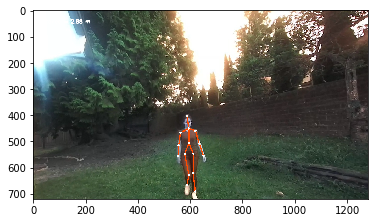

examples/raw/1382_5.97_raw.jpg
headToNeck =  17.029386365926403
distance =  7.9838927876658135


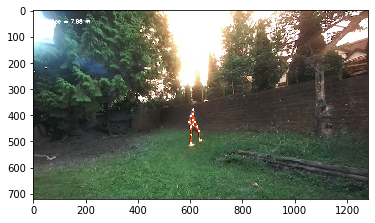

examples/raw/6893_2.05_raw.jpg
headToNeck =  49.49747468305833
distance =  2.960997866174509


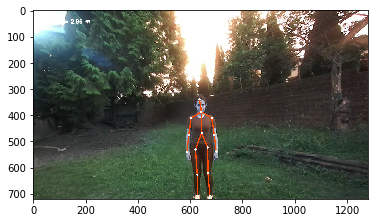

examples/raw/1798_7.42_raw.jpg
headToNeck =  17.0
distance =  7.823573644546901


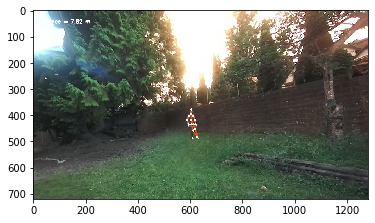

examples/raw/1000_4.69_raw.jpg
headToNeck =  31.78049716414141
distance =  4.220968503210612


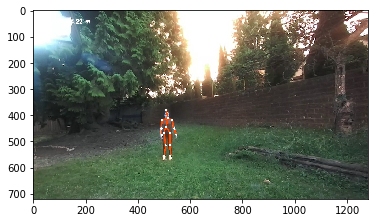

examples/raw/3531_7.87_raw.jpg
headToNeck =  25.0
distance =  5.403601750731468


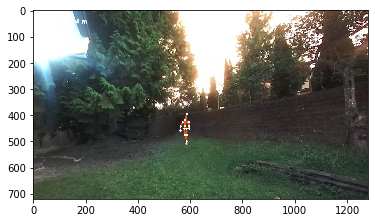

examples/raw/7040_2.33_raw.jpg
headToNeck =  52.773099207835045
distance =  2.7237073543110113


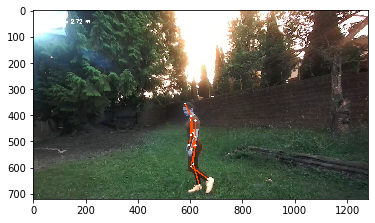

examples/raw/3728_2.29_raw.jpg
headToNeck =  55.0
distance =  2.528135072101246


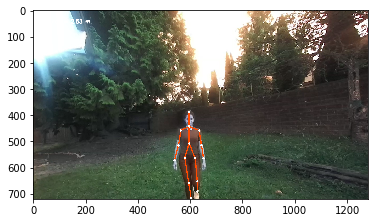

In [50]:
# run pose and distance.
viz = visualize_depth_pose(depth_maps[:,:].copy(), glob.glob(input))

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


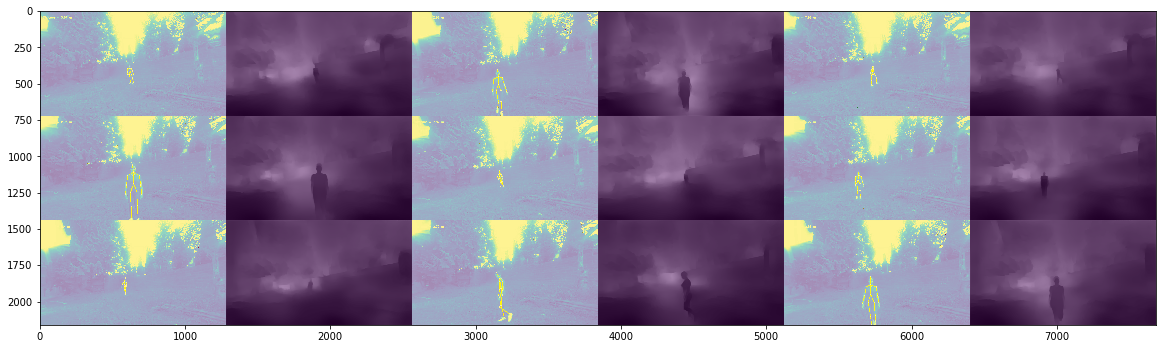

In [51]:
fig = plt.figure(figsize=(20,20))
plt.imshow(viz[:,:,:])
plt.imshow(viz[:,:,0], alpha=0.5)
plt.show()

# Social Distance Robot

Assume you have a robot which you want it to warn the human in front of it to keep the distance. Write a simple code that prints a warning when the predicted distance is not considered.

In [52]:
#CODE HERE

# RMSE

Root Mean Square Error (RMSE) is a standard way to measure the error of a model in predicting quantitative data.
Try evaluating the network performance by calculating the RMSE. Also try plotting a meaningful graph with the error.

In [53]:
#CODE HERE

# Orientation Detection
Try finding the detected body's orientation using what you have learned so far (Open Pose + Dense Depth)

In [54]:
#CODE HERE